# Util

In [13]:
# !python -m pip install tensorflow keras
# !python -m pip install scikit-learn
# !python -m pip install nltk

In [14]:
# !pip install tensorflow==2.8.2

In [15]:
# !pip install --upgrade tensorflow scikeras keras

In [16]:
# import tensorflow as tf
# print("Version de TensorFlow:", tf.__version__)

# tf.config.list_physical_devices()

In [17]:
# import tensorflow as tf
# tf.config.experimental.list_physical_devices()
# tf.config.list_physical_devices()
# tf.test.gpu_device_name()

In [18]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Import

In [3]:
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten,BatchNormalization,MaxPooling1D,SpatialDropout1D
from keras import regularizers
from keras import utils
from keras.callbacks import EarlyStopping

import re
import os
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\doria\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Coder le texte

## Récupération des textes et des années de publications (labels)

In [5]:
# Définition de la seed pour la reproductibilité des résultats
utils.set_random_seed(42)

# Chemin du dossier contenant les textes
dossier_textes = 'CORPUS DATATION TER'

# Récupérer la liste des noms de fichiers dans le dossier
fichiers = os.listdir(dossier_textes)

# Trier les fichiers par ordre alphabétique
fichiers.sort()

# Initialiser une liste pour stocker les textes
books = []

# Initialiser une liste pour stocker les années extraites des noms de fichiers
y = []

# Parcourir les fichiers et lire leur contenu
for fichier in fichiers[:100]:
    chemin_fichier = os.path.join(dossier_textes, fichier)
    with open(chemin_fichier, 'r', encoding='utf-8') as f:

        texte = f.read()

        # Extraire l'année du nom de fichier
        annee = re.search(r'\((\d{4})\)', fichier)  # Utilisation d'une expression régulière pour trouver l'année entre parenthèses
        # Si une année est trouvée, alors nous pouvons étudier le livre, nous l'ajoutons ainsi que son label dans les listes associées
        if annee:
            books.append(texte)
            annee_int = int(annee.group(1)) # Récupérer l'année
            y.append(annee_int)  # Ajouter l'année extraite à la liste des labels

# Division de notre bdd en deux bdd, l'une pour l'entrainement et l'autre pour les tests
X_train, X_test, y_train, y_test = train_test_split(books, y, test_size=0.1, random_state=42)
X_train,X_val,y_train,y_val =  train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Afficher les annéees extraites
print(y_train)
#print(len(X_train[9]))

[1954, 1972, 1858, 1955, 2013, 1893, 1990, 1942, 1944, 1887, 1908, 1899, 2012, 1988, 2002, 1997, 1970, 1865, 1958, 1874, 1942, 1996, 1953, 1910, 2018, 2006, 2013, 1913, 1988, 1893, 1986, 1982, 2006, 2013, 1967, 1986, 1924, 1909, 1893, 1899, 1858, 1891, 2003, 1858, 1988, 2015, 1869, 2015, 1972, 1860, 1960, 1950, 1857, 1964, 1978, 1890, 2007, 2014, 2011, 1871, 1892, 1895, 1914, 1863, 1970, 2006, 1934, 2011, 1940, 1922, 2001, 1986]


## Tokenization + division en sequence

### Classe Fonction et Variable

In [10]:
# Longueur maximale des séquences
max_len = 10000

In [6]:
class WordTokenizer:
    def __init__(self):
        self.word_to_number = {}
        self.next_number = 1

    def tokenize(self, list_of_texts):
        total_texts = len(list_of_texts)
        token_lists = []
        for i, text in enumerate(list_of_texts):
            # Les textes sont déjà pré traité (tout est déjà en minuscule)
            # text = text.lower()
            tokens = word_tokenize(text)
            token_lists.append([])

            for token in tokens:
                if token not in self.word_to_number:
                    self.word_to_number[token] = self.next_number
                    self.next_number += 1

                token_lists[-1].append(self.word_to_number[token])

            percentage = (i + 1) / total_texts * 100
            print(f"Progress: {percentage:.2f}% complete")

        print("\nTokenization complete.")
        return token_lists, self.next_number
    
    def tokenizeNoAdd(self, list_of_texts):
        total_texts = len(list_of_texts)
        token_lists = []
        for i, text in enumerate(list_of_texts):
            text = text.lower()
            tokens = word_tokenize(text)
            token_lists.append([])

            for token in tokens:
                if token not in self.word_to_number:
                    token_lists[-1].append(0)
                else:
                    token_lists[-1].append(self.word_to_number[token])

            percentage = (i + 1) / total_texts * 100
            print(f"Progress: {percentage:.2f}% complete")

        print("\nTokenization complete.")
        return token_lists, self.next_number

In [7]:
def diviser_liste(liste,labels, taille):
    resultats = []
    res_labels = []
    ind = 0
    # Parcours de chaque sous-liste dans la liste principale
    for sous_liste in liste:
        longueur = len(sous_liste)
        if(longueur<taille):
            ind+=1
            continue
        nbtour = round(longueur/taille)
        lastpos=0
        # Division de la sous-liste en morceaux de taille spécifiée
        for i in range(nbtour):
            if(lastpos + taille > longueur):
              if((lastpos + taille)-longueur < max_len/2):
                  continue
              lastpos -= (lastpos + taille)-longueur

            # Ajout du morceau à la liste de résultats
            resultat = sous_liste[lastpos:lastpos + taille]
            lastpos = lastpos + taille
            resultats.append(resultat)

            # A chaque fois que je divisie, jajoute le label au meme indice
            res_labels.append(labels[ind])
        ind+=1

    return resultats,res_labels

### Training Data

In [8]:
tokenizer = WordTokenizer()
# Transformation de chaque texte dans X_train en une séquence d'entiers
sequences, token_number = tokenizer.tokenize(X_train)

Progress: 1.39% complete
Progress: 2.78% complete
Progress: 4.17% complete
Progress: 5.56% complete
Progress: 6.94% complete
Progress: 8.33% complete
Progress: 9.72% complete
Progress: 11.11% complete
Progress: 12.50% complete
Progress: 13.89% complete
Progress: 15.28% complete
Progress: 16.67% complete
Progress: 18.06% complete
Progress: 19.44% complete
Progress: 20.83% complete
Progress: 22.22% complete
Progress: 23.61% complete
Progress: 25.00% complete
Progress: 26.39% complete
Progress: 27.78% complete
Progress: 29.17% complete
Progress: 30.56% complete
Progress: 31.94% complete
Progress: 33.33% complete
Progress: 34.72% complete
Progress: 36.11% complete
Progress: 37.50% complete
Progress: 38.89% complete
Progress: 40.28% complete
Progress: 41.67% complete
Progress: 43.06% complete
Progress: 44.44% complete
Progress: 45.83% complete
Progress: 47.22% complete
Progress: 48.61% complete
Progress: 50.00% complete
Progress: 51.39% complete
Progress: 52.78% complete
Progress: 54.17% co

In [11]:
# Division des données en séquences de longueur maximale max_len
data_train, y_train = diviser_liste(sequences, y_train, max_len)

#data_train = [[[x] for x in sublist] for sublist in data_train]

# Affichage de y_train
print("y_train:", y_train)

# Conversion en tableau numpy
y_train = np.array(y_train)
data_train = np.array(data_train)

# Affichage de la longueur des données
print("Nombre de séquences de données:", len(data_train))

# Affichage du nombre total d'index dans le tokenizer
print("Nombre total d'index dans le tokenizer:", token_number)

y_train: [1954, 1954, 1954, 1972, 1972, 1972, 1972, 1972, 1858, 1858, 1858, 1858, 1858, 1955, 1955, 1955, 1955, 1955, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 1893, 1893, 1893, 1990, 1990, 1990, 1990, 1990, 1942, 1942, 1942, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1944, 1887, 1908, 1908, 1908, 1908, 1908, 1908, 1908, 1908, 1908, 1908, 1908, 1908, 1908, 1899, 1899, 1899, 2012, 2012, 2012, 1988, 1988, 1988, 1988, 1988, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1970, 1970, 1970, 1970, 1970, 1970, 1865, 1865, 1865, 1865, 1865, 1865, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1874, 1874, 1874, 1874, 1874, 1874, 1874, 1874, 

### Test et Validation Data

In [12]:
# Transformation de chaque texte dans X_test en une séquence d'entiers
sequences_test, _ = tokenizer.tokenizeNoAdd(X_test)

# Transformation de chaque texte dans X_val en une séquence d'entiers
sequences_val, _ = tokenizer.tokenizeNoAdd(X_val)

Progress: 10.00% complete
Progress: 20.00% complete
Progress: 30.00% complete
Progress: 40.00% complete
Progress: 50.00% complete
Progress: 60.00% complete
Progress: 70.00% complete
Progress: 80.00% complete
Progress: 90.00% complete
Progress: 100.00% complete

Tokenization complete.
Progress: 5.56% complete
Progress: 11.11% complete
Progress: 16.67% complete
Progress: 22.22% complete
Progress: 27.78% complete
Progress: 33.33% complete
Progress: 38.89% complete
Progress: 44.44% complete
Progress: 50.00% complete
Progress: 55.56% complete
Progress: 61.11% complete
Progress: 66.67% complete
Progress: 72.22% complete
Progress: 77.78% complete
Progress: 83.33% complete
Progress: 88.89% complete
Progress: 94.44% complete
Progress: 100.00% complete

Tokenization complete.


In [13]:
data_test,y_test = diviser_liste(sequences_test,y_test,max_len)

# Transformer la liste de listes de flottants en une liste de listes de listes
#data_test = [[[x] for x in sublist] for sublist in data_test]

# Convertir en tableau numpy
y_test = np.array(y_test)
data_test = np.array(data_test)

data_val,y_val = diviser_liste(sequences_val,y_val,max_len)

#data_val = [[[x] for x in sublist] for sublist in data_val]

# Convertir en tableau numpy
y_val = np.array(y_val)
data_val = np.array(data_val)

### Binary Conversion (a la place de lembedding = mauvais)

In [28]:
# def int_to_binary_list(number, max_bits):
#     # Convertir l'entier en chaîne binaire en enlevant le préfixe '0b'
#     binary_string = bin(number)[2:]

#     # Ajouter des zéros à gauche pour atteindre le nombre maximal de bits
#     padded_binary_string = binary_string.zfill(max_bits)

#     # Convertir la chaîne binaire en tableau NumPy d'entiers
#     binary_array = np.array([int(bit) for bit in padded_binary_string])

#     return binary_array

# # Fonction pour convertir chaque entier d'un tableau NumPy en sa représentation binaire
# def array_of_ints_to_binary_list(array_of_ints, max_bits):
#     binary_representation = np.array([int_to_binary_list(num, max_bits) for sublist in array_of_ints for num in sublist])
#     binary_representation = binary_representation.reshape(array_of_ints.shape[0], array_of_ints.shape[1], max_bits)
#     return binary_representation

# # Exemple d'utilisation avec un tableau NumPy
# array_of_ints = data
# max_bits = 19  # Nombre maximum de bits pour représenter 272877

# resultat = array_of_ints_to_binary_list(array_of_ints, max_bits)
# print(resultat)

# Définition des architectures des modeles testés

In [29]:
# # Construction du modèle
# # Pilee linéaire de couches. Dans ce modèle, les données passent à travers les couches dans l'ordre où elles ont été ajoutées.
# model = Sequential()
# # L'embedding est une représentation dense des mots (ou des tokens) dans un espace vectoriel.
# # L'objectif principal de l'embedding est de capturer les similarités sémantiques entre les mots en les plaçant dans un espace vectoriel où les mots ayant des significations similaires sont plus proches les uns des autres.
# model.add(Embedding(max_words, embedding_dim, input_length=max_len))

# # Couche de convolution à une dimension (1D) au modèle. Cette couche va utiliser 128 filtres de taille 10 avec une fonction d'activation ReLU (Rectified Linear Unit).
# # La convolution 1D est utilisée pour extraire des caractéristiques séquentielles des données.
# model.add(Conv1D(128,10, activation='relu'))

# # Le pooling global maximale extrait les caractéristiques les plus significatives de chaque canal de la sortie de la couche précédente, réduisant ainsi la dimensionnalité des données.
# model.add(GlobalMaxPooling1D())

# # Couche dense (entièrement connectée) au modèle avec 128 neurones et une fonction d'activation ReLU.
# model.add(Dense(128, activation='relu'))

# # Le dropout est une technique de régularisation qui désactive aléatoirement un pourcentage (dans ce cas, 50%) des neurones de la couche précédente pendant l'entraînement,
# # ce qui aide à prévenir le surapprentissage.
# model.add(Dropout(0.5))

# # Couche dense de sortie au modèle avec un seul neurone et une fonction d'activation linéaire.
# # Dans ce cas, la sortie est une seule valeur, qui est la date de publication prédite.
# model.add(Dense(1, activation='linear'))

# # La fonction ReLU est couramment utilisée dans les réseaux de neurones en raison de sa simplicité et de sa capacité à introduire une non-linéarité dans le modèle,
# # ce qui permet au réseau de capturer des motifs complexes dans les données.

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# model.summary()

# # Entraînement du modèle
# model.fit(data, y_train, epochs=50, batch_size=32)
# #, validation_split=0.2
# # Après l'entraînement, vous pouvez utiliser le modèle pour prédire la date de publication d'un nouveau livre.


In [15]:
embedding_dim = 50

def archi(model_params):
    model = Sequential()

    model.add(Embedding(input_dim=token_number, output_dim=model_params['embedding_dim'], input_length=max_len))
    model.add(Conv1D(model_params['conv1D_1_filters'], model_params['conv1D_1_kernel'], activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1))
    return model

def archi_3CONV32_F_DE_DR_DE():
    """
    Fonction définissant l'architecture du modèle avec 3 couches de convolution.

    Returns:
    - model: Modèle Keras Sequential défini avec les couches spécifiées.
    """
    # Pile linéaire de couches. 
    # Dans ce modèle, les données passent à travers les couches dans l'ordre où elles ont été ajoutées.
    model = Sequential()

    # L'embedding est une représentation dense des mots (ou des tokens) dans un espace vectoriel.
    # L'objectif principal de l'embedding est de capturer les similarités sémantiques entre les mots en les plaçant
    # dans un espace vectoriel où les mots ayant des significations similaires sont plus proches les uns des autres.
    # input_dim le nombre de vocabulaire, input_length le nombre d'éléments dans une liste, output_dim la dimension de
    # chaque vecteur.
    model.add(Embedding(input_dim=token_number, output_dim=embedding_dim, input_length=max_len))

    # Couche de convolution à une dimension (1D) au modèle.
    # Cette couche va utiliser 16 filtres de taille 9 avec une fonction d'activation ReLU (Rectified Linear Unit).
    model.add(Conv1D(32, 301, activation='relu'))

    # Réduction de dimension par l'opération de pooling.
    model.add(MaxPooling1D(2))

    # Deuxième couche de convolution avec 32 filtres de taille 7 et activation ReLU.
    model.add(Conv1D(32, 301, activation='relu'))

    # Réduction de dimension par l'opération de pooling.
    model.add(MaxPooling1D(2))

    # Troisième couche de convolution avec 64 filtres de taille 3 et activation ReLU.
    model.add(Conv1D(32, 301, activation='relu'))

    # Réduction de dimension par l'opération de pooling.
    model.add(MaxPooling1D(2))

    # Transformation des données en un format adapté à une couche Dense.
    model.add(Flatten())

    # Couche dense de 512 neurones avec activation ReLU et régularisation L2.
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1)))

    # Dropout pour éviter le surapprentissage.
    model.add(Dropout(0.05))

    # Couche de sortie avec une seule sortie.
    model.add(Dense(1))

    return model



# La fonction ReLU est couramment utilisée dans les réseaux de neurones en raison de sa simplicité et de sa capacité à introduire une non-linéarité dans le modèle,
# ce qui permet au réseau de capturer des motifs complexes dans les données.

In [31]:
# def archi_3CONV16_F_DE_DR_DE():
#   model = Sequential()

#   model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
#   model.add(Conv1D(16, 5, activation='relu'))
#   model.add(Conv1D(16, 5, activation='relu'))
#   model.add(Conv1D(16, 5, activation='relu'))
#   model.add(Flatten())
#   model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
#   model.add(Dropout(0.5))
#   model.add(Dense(1))
#   return model

# def archi_3CONV64_F_DE_DR_DE():
#   model = Sequential()

#   model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
#   model.add(Conv1D(64, 21, activation='relu'))
#   model.add(MaxPooling1D(pool_size=2))  # Ajout de la couche MaxPooling1D
#   model.add(Conv1D(64, 21, activation='relu'))
#   model.add(MaxPooling1D(pool_size=2))  # Ajout de la couche MaxPooling1D
#   model.add(Flatten())
#   model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
#   model.add(Dropout(0.4))
#   model.add(Dense(1))

#   return model

# def archi_3CONV64_32_16_F_DE_DR_DE():
#   model = Sequential()

#   model.add(Conv1D(128, 49, activation='relu', input_shape=(5000, 19)))
#   model.add(Flatten())
#   model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
#   model.add(Dropout(0.4))
#   model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-6)))
#   model.add(Dense(1))

#   return model

# Entrainement des models

## Trouver le meilleur

In [32]:
# # Définir la liste des modèles à évaluer
# models = [archi_3CONV32_F_DE_DR_DE(), archi_3CONV16_F_DE_DR_DE(), archi_3CONV64_F_DE_DR_DE(), archi_3CONV64_32_16_F_DE_DR_DE()]

# best_model = None
# best_val_loss = float('inf')
# best_val_mae = float('inf')

# # Entraîner et évaluer chaque modèle
# for model in models:
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     model.fit(data, y_train, epochs=20, batch_size=64, validation_data=(data_val, y_val))

#     # Évaluer sur l'ensemble de test
#     val_loss, val_mae = model.evaluate(data_test, y_test)

#     # Mettre à jour le meilleur modèle si nécessaire
#     if val_mae < best_val_mae:
#         best_val_loss = val_loss
#         best_val_mae = val_mae
#         best_model = model

# # Afficher les performances du meilleur modèle
# print("Le meilleur modèle est:")
# best_model.summary()
# print("Meilleure valeur de perte (loss) sur l'ensemble de test:", best_val_loss)
# print("Meilleure MAE (Mean Absolute Error) sur l'ensemble de test:", best_val_mae)


In [33]:
# model = best_model

## Ou en entrainer un seul

### Test avec plusieurs params

In [150]:
# import random

# # Create a list to store 50 model_params
# list_of_params = []

# # Define the range of values for each parameter
# embedding_dim_range = range(5, 15)  # Change the range as needed
# conv1D_1_filters_range = range(32, 256)  # Change the range as needed
# conv1D_1_kernel_range = range(5, 101)  # Change the range as needed

# # Iterate to create 50 model_params with random values
# for _ in range(50):
#     # Generate random values for each parameter
#     embedding_dim = random.choice(embedding_dim_range)
#     conv1D_1_filters = random.choice(conv1D_1_filters_range)
#     conv1D_1_kernel = random.choice(conv1D_1_kernel_range)
    
#     # Create a dictionary for the current model_params
#     params = {
#         'embedding_dim': embedding_dim,
#         'conv1D_1_filters': conv1D_1_filters,
#         'conv1D_1_kernel': conv1D_1_kernel
#     }
    
#     # Append the params to the list_of_params
#     list_of_params.append(params)

In [151]:
# def compile(model_params):
#     utils.set_random_seed(42)

#     # Création du modèle en utilisant l'architecture spécifiée
#     model = archi(model_params)

#     # Compilation du modèle avec l'optimiseur Adam, la fonction de perte 'mse' et la métrique 'mae'
#     model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
#     # Affichage de la structure du modèle
#     model.summary()

#     # Création du callback EarlyStopping pour surveiller la perte d'entraînement
#     early_stopping = EarlyStopping(monitor='loss', patience=3)

#     # Création du callback EarlyStopping pour surveiller la perte de validation
#     early_stopping_val = EarlyStopping(monitor='val_loss', patience=3)

#     # Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
#     history = model.fit(data_train, y_train, epochs=200, batch_size=32, validation_data=(data_val, y_val), callbacks=[early_stopping, early_stopping_val])

#     return model,history

In [153]:
# def evaluate(model,model_params):
#     # Evaluate the model on the test data
#     print("Evaluation on Test Data:")
#     loss_test,mae_test = model.evaluate(data_test, y_test)
#     print()

#     # Evaluate the model on the training data
#     print("Evaluation on Training Data:")
#     loss_train,mae_train = model.evaluate(data_train, y_train)
#     print()

#     # Evaluate the model on the validation data
#     print("Evaluation on Validation Data:")
#     loss_validation,mae_validation = model.evaluate(data_val, y_val)
#     print()

#     # Charger les données à partir du fichier CSV
#     mae_data = pd.read_csv('mae_data.csv')

#     nouvelle_ligne = [mae_test,loss_test,mae_train,loss_train,mae_validation,loss_validation,
#                     model_params['embedding_dim'],model_params['conv1D_1_filters'],model_params['conv1D_1_kernel']]

#     # Ajouter la nouvelle ligne à la DataFrame
#     mae_data.loc[len(mae_data)] = nouvelle_ligne

#     mae_data.to_csv('mae_data.csv', index=False)

#     # Afficher les données mises à jour
#     #display(mae_data)

In [154]:
# for model_params in list_of_params:
#     model,history = compile(model_params)
#     evaluate(model,model_params)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 1000, 12)          3137268   
                                                                 
 conv1d_24 (Conv1D)          (None, 964, 167)          74315     
                                                                 
 flatten_22 (Flatten)        (None, 160988)            0         
                                                                 
 dense_24 (Dense)            (None, 1)                 160989    
                                                                 
Total params: 3,372,572
Trainable params: 3,372,572
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1773/1773 [==============================] - 39s 22ms/step - loss: 47781.2656 - mae: 59.7042 - val_loss: 2330.0461 - val_mae: 34.8699
Epoch 2/200
1773/1773 [======

KeyboardInterrupt: 

In [ ]:
mae_data = pd.read_csv('mae_data.csv')
display(mae_data)

### Un seul

In [18]:
utils.set_random_seed(42)

model_params = {'embedding_dim': 10, 'conv1D_1_filters': 256,'conv1D_1_kernel': 9 }

# Création du modèle en utilisant l'architecture spécifiée
model = archi(model_params)

# Compilation du modèle avec l'optimiseur Adam, la fonction de perte 'mse' et la métrique 'mae'
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# Affichage de la structure du modèle
model.summary()

# Création du callback EarlyStopping pour surveiller la perte d'entraînement
early_stopping = EarlyStopping(monitor='loss', patience=3)

# Création du callback EarlyStopping pour surveiller la perte de validation
early_stopping_val = EarlyStopping(monitor='val_loss', patience=3)

# Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
history = model.fit(data_train, y_train, epochs=200, batch_size=32, validation_data=(data_val, y_val), callbacks=[early_stopping, early_stopping_val])

# L'historique de l'entraînement
history.history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 10)         862740    
                                                                 
 conv1d_1 (Conv1D)           (None, 9992, 256)         23296     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4996, 256)        0         
 1D)                                                             
                                                                 
 dense_2 (Dense)             (None, 4996, 64)          16448     
                                                                 
 dropout_1 (Dropout)         (None, 4996, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 319744)            0         
                                                      

{'loss': [3365637.25,
  485606.8125,
  69334.609375,
  16286.2060546875,
  3498.765380859375,
  1933.6844482421875,
  1256.309326171875,
  1030.4427490234375,
  759.8486328125,
  553.0935668945312,
  430.9843444824219,
  339.3645324707031,
  278.0878601074219,
  248.16317749023438,
  187.9751434326172,
  158.0008544921875,
  134.80218505859375,
  119.67839813232422,
  111.36823272705078,
  106.40740966796875,
  87.91007232666016,
  77.47954559326172,
  67.8511962890625,
  56.26486587524414,
  54.33677673339844,
  52.022647857666016,
  43.68667984008789,
  41.9050407409668,
  37.911808013916016,
  30.236352920532227,
  28.61664390563965,
  26.95269203186035,
  25.255773544311523,
  24.594297409057617,
  24.76629066467285,
  21.564851760864258,
  20.34165382385254,
  19.35065460205078,
  18.934226989746094,
  17.366947174072266,
  17.427669525146484,
  14.175833702087402,
  15.741216659545898,
  14.593650817871094,
  14.58646297454834],
 'mae': [1829.0008544921875,
  600.7810668945312,
 

In [ ]:
# # Entraînement du modèle avec les données d'entraînement et de validation, en utilisant EarlyStopping pour éviter le surapprentissage
# history = model.fit(data_train, y_train, epochs=10, batch_size=32, validation_data=(data_val, y_val), callbacks=[early_stopping, early_stopping_val])

# # L'historique de l'entraînement
# history.history

# Evaluation du model

In [17]:
# Evaluate the model on the test data
print("Evaluation on Test Data:")
loss_test,mae_test = model.evaluate(data_test, y_test)
print()

# Evaluate the model on the training data
print("Evaluation on Training Data:")
loss_train,mae_train = model.evaluate(data_train, y_train)
print()

# Evaluate the model on the validation data
print("Evaluation on Validation Data:")
loss_validation,mae_validation = model.evaluate(data_val, y_val)
print()

Evaluation on Test Data:
4/4 [==============================] - 0s 63ms/step - loss: 2165.2568 - mae: 40.7325

Evaluation on Training Data:
17/17 [==============================] - 0s 10ms/step - loss: 10.3716 - mae: 2.2952

Evaluation on Validation Data:
5/5 [==============================] - 0s 10ms/step - loss: 824.9333 - mae: 23.0427



# Save in DF

In [115]:
# mae_data = pd.DataFrame()

# mae_data['Test_MAE'] = [mae_test]
# mae_data['Test_MSE'] = [loss_test]
# mae_data['Train_MAE'] = [mae_train]
# mae_data['Train_MSE'] = [loss_train]
# mae_data['Val_MAE'] = [mae_validation]
# mae_data['Val_MSE'] = [loss_validation]

# # Add columns for each element in model_params
# for key, value in model_params.items():
#     mae_data[key] = value

# mae_data.to_csv('mae_data.csv', index=False)

# # Afficher les données
# display(mae_data)

,Test_MAE,Test_MSE,Train_MAE,Train_MSE,Val_MAE,Val_MSE,embedding_dim,conv1D_1_filters,conv1D_1_kernel
0,21.231134,814.542419,0.668971,0.916312,19.41028,713.596619,10,32,9


In [136]:
# Charger les données à partir du fichier CSV
mae_data = pd.read_csv('mae_data.csv')

nouvelle_ligne = [mae_test,loss_test,mae_train,loss_train,mae_validation,loss_validation,
                  model_params['embedding_dim'],model_params['conv1D_1_filters'],model_params['conv1D_1_kernel']]

# Ajouter la nouvelle ligne à la DataFrame
mae_data.loc[len(mae_data)] = nouvelle_ligne

mae_data.to_csv('mae_data.csv', index=False)

# Afficher les données mises à jour
display(mae_data)

,Test_MAE,Test_MSE,Train_MAE,Train_MSE,Val_MAE,Val_MSE,embedding_dim,conv1D_1_filters,conv1D_1_kernel
0,21.231134,814.542419,0.668971,0.916312,19.410280,713.596619,10.0,32.0,9.0
1,23.095755,1275.975098,1.803560,6.659859,25.241987,1215.574951,10.0,32.0,21.0
2,25.501158,1566.790771,5.923900,64.913734,28.319826,1571.092773,10.0,32.0,31.0
3,25.728455,1648.863770,5.700406,60.525574,28.680996,1613.620972,10.0,32.0,41.0
4,27.242691,1805.061646,3.703882,23.175650,30.969715,1788.279907,10.0,32.0,101.0
5,32.056061,2134.288574,0.837420,1.714122,33.010803,1952.237427,10.0,32.0,301.0
6,22.383560,1001.229858,1.998984,8.208273,22.873327,1027.974854,10.0,64.0,9.0
7,21.825577,839.235046,1.396211,4.365321,22.282118,909.433533,10.0,128.0,9.0


# Predictions

In [204]:
# Utiliser le modèle pour prédire les dates sur les données de test
predictions = model.predict(data_test)

# Afficher les dates prédites
print("Dates prédites :")
for prediction in predictions:
    print(prediction)

24/24 [==============================] - 1s 13ms/step
Dates prédites :
[2002.1658]
[2002.6288]
[1994.9685]
[1964.3569]
[1989.1569]
[1936.9858]
[1947.4579]
[1981.7827]
[1972.412]
[1972.8263]
[1975.8949]
[1956.1937]
[1980.731]
[2009.8079]
[1991.2706]
[1992.6387]
[1909.1914]
[1893.6179]
[1920.4586]
[1883.1821]
[1883.7125]
[1872.349]
[1890.285]
[1895.4407]
[1906.8429]
[1931.3147]
[1927.5636]
[1947.4706]
[1945.9929]
[1937.9318]
[1955.4027]
[1936.3506]
[1946.0314]
[1960.4708]
[1940.9398]
[1948.1068]
[1933.0089]
[1947.212]
[1935.4078]
[1954.1335]
[1933.0483]
[1964.505]
[1940.995]
[1945.0023]
[1939.4933]
[1944.7562]
[1959.8075]
[1940.1273]
[1894.2994]
[1864.1996]
[1914.3429]
[1906.1324]
[1889.0765]
[1872.7555]
[1873.4293]
[2001.8735]
[1996.9554]
[1986.3584]
[1997.1283]
[2008.8392]
[2012.019]
[2003.4225]
[2008.6559]
[1971.2443]
[1991.8625]
[1886.0146]
[1876.3552]
[1846.3756]
[1879.916]
[1882.0565]
[1874.224]
[1861.5815]
[1884.697]
[1883.4781]
[1885.3755]
[1873.9229]
[1888.7252]
[1880.251]
[1879

# Graphes

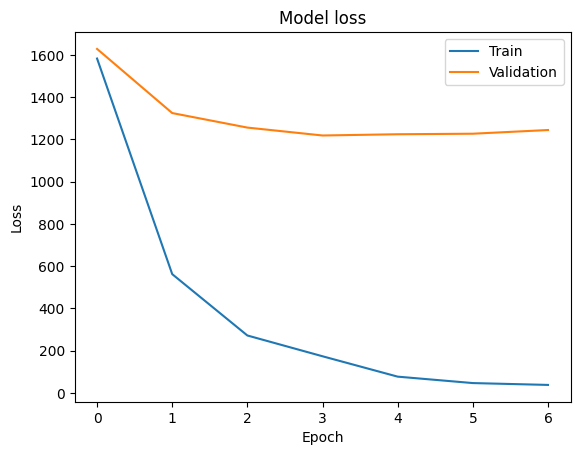

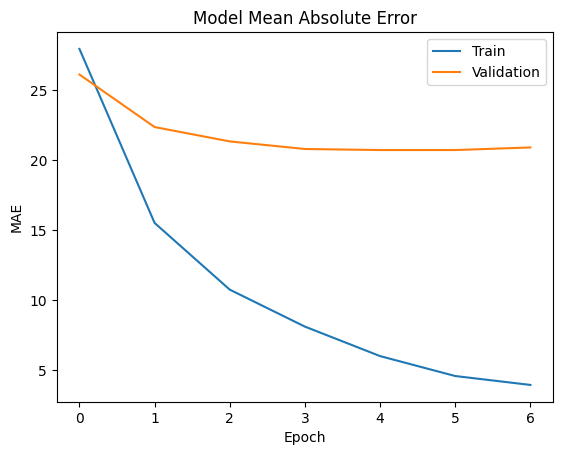

24/24 [==============================] - 0s 17ms/step


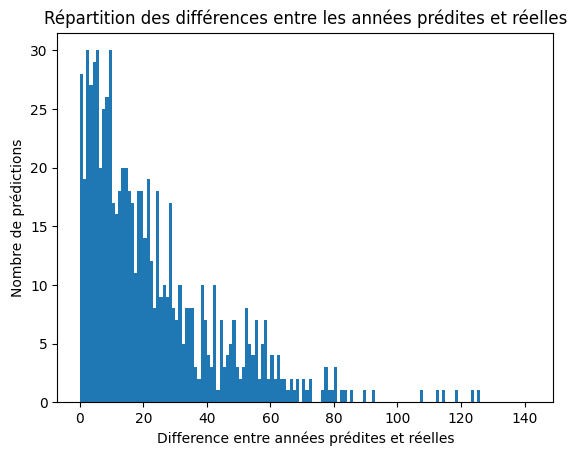

24/24 [==============================] - 0s 14ms/step
Accuracy avec exacte matching: 2.216427640156454 %
Accuracy avec tolerance de 15 est: 47.327249022164274 %


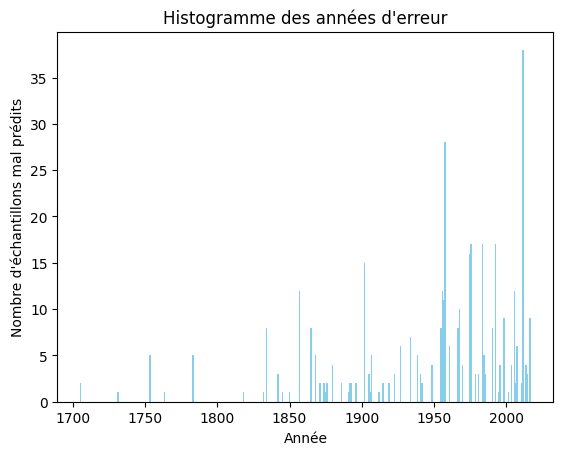

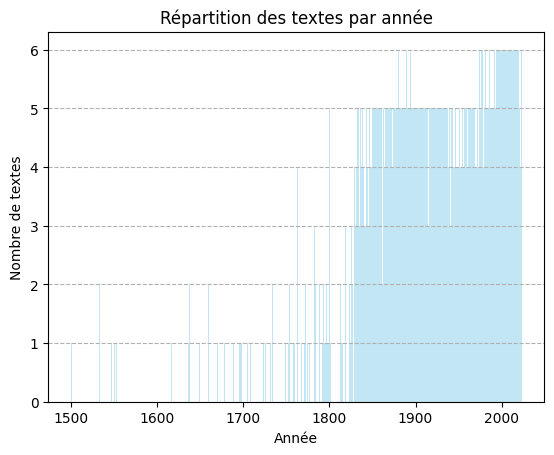

In [205]:
# Plot training & validation loss values
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#Plot MAE
plt.plot(history.history['mae'][1:]) 
plt.plot(history.history['val_mae'][1:]) 
plt.title('Model Mean Absolute Error') 
plt.ylabel('MAE') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper right') 
plt.show()

#Calcul de la différence entre les années prédites et les années réelles
y_pred = model.predict(data_test) 
diff = np.abs(y_test - y_pred.flatten())

#le dernier bin
max_diff = np.max(diff)

#Plot de l'histogramme des différences entre les années prédites et réelles
plt.hist(diff, bins=np.arange(0,max_diff,1)) 
plt.xlabel('Difference entre années prédites et réelles') 
plt.ylabel('Nombre de prédictions') 
plt.title('Répartition des différences entre les années prédites et réelles') 
plt.show()


#-----------------------------------voir quelle année est la plus dure----------------------------------#
y_pred = model.predict(data_test)
error_samples = []
exact_matches_count = 0

for i in range(len(y_test)):
    if round(y_pred[i][0]) != y_test[i]:
        error_samples.append(y_test[i])
    else:
        exact_matches_count += 1

accuracy_exact_matches = (exact_matches_count / len(y_test)) * 100

print("Accuracy avec exacte matching:", accuracy_exact_matches, "%")


#------------------------voir quelle année est la plus dure (tolerance de 15)---------------------------#
error_samples = []
tolerance = 15
within_tolerance_count = 0

for i in range(len(y_test)):
    if abs(round(y_pred[i][0]) - y_test[i]) > tolerance:
        error_samples.append(y_test[i])
    else:
        within_tolerance_count += 1

accuracy_within_tolerance = (within_tolerance_count / len(y_test)) * 100

print("Accuracy avec tolerance de", tolerance, "est:", accuracy_within_tolerance, "%")


# Créer un histogramme des années d'erreur
plt.hist(error_samples, bins=max(y_test)-min(y_test)+1, color='skyblue')
plt.xlabel('Année')
plt.ylabel('Nombre d\'échantillons mal prédits')
plt.title('Histogramme des années d\'erreur')
plt.show()


#------------------- Créer un histogramme pour visualiser la répartition des textes par année---------------#

plt.hist(y, bins=range(min(y), max(y) + 1), alpha=0.5,color='skyblue')
plt.grid(axis='y', linestyle='--')
plt.xlabel('Année')
plt.ylabel('Nombre de textes')
plt.title('Répartition des textes par année')
plt.show()

# Load & Save Model

In [40]:
# Sauvegarder le modèle complet au format HDF5
#model.save('modelV5.h5')

In [41]:
# Charger le modèle complet
# from keras.models import load_model
# model = load_model('modelV4.h5')

# model.summary()